## Load the Restaurants dataset that was crawled from TripAdvisor

There are 7929 different restaurants that was crawled from TripAdvisor. Each row represents a unique restaurant and includes information such as address, geometry point, name, primaryRating (from 0 to 5), number of reviews, etc.

In [18]:
import geopandas as gpd
import pandas as pd
import pyproj
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import shape, mapping, Point, Polygon, MultiPolygon
restaurant = pd.read_csv('restaurants.csv')
restaurant['longitude'] = pd.to_numeric(restaurant['longitude'], errors='coerce')
restaurant['latitude'] = pd.to_numeric(restaurant['latitude'], errors='coerce')
restaurant['longitude'], restaurant['latitude'] = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init='epsg:3414'), np.array(restaurant['longitude']), np.array(restaurant['latitude']))
geometry = [Point(xy) for xy in zip(restaurant.longitude, restaurant.latitude)]
restaurant = restaurant.drop(['longitude', 'latitude'], axis=1)
gdf_restaurant = gpd.GeoDataFrame(restaurant, crs="EPSG:3414", geometry=geometry)
gdf_restaurant.head(5)

Unnamed: 0   geoId     neighborhood  \
0           0  294265        Boulevard   
1           1  294265      Tanjong Rhu   
2           2  294265  Holland Village   
3           3  294265       Paya Lebar   
4           4  294265    Marine Parade   

                                             address  \
0  2 Orchard Turn Ion Orchard B4-36 ION Orchard, ...   
1  5 Stadium Walk Floor 02 Leisure Park Kallang 4...   
2  34 Lorong Mambong Holland Village Holland Vill...   
3  18 Tampines Industrial Crescent Space@Tampines...   
4  171 East Coast Road Santa Grand Hotel East Coa...   

                                      primaryRanking  primaryRating  \
0  {'rank': 20, 'totalCount': 359, 'category': 'F...            4.0   
1  {'rank': 727, 'totalCount': 1633, 'category': ...            4.0   
2  {'rank': 23, 'totalCount': 70, 'category': 'Me...            4.0   
3  {'rank': 103, 'totalCount': 133, 'category': '...            3.5   
4  {'rank': 27, 'totalCount': 70, 'category': 'Me...            4.0   

   reviewCount                                    priceRange  \
0          108  [{'tagId': 10953, 'tagValue': 'Cheap Eats'}]   
1           15   [{'tagId': 10955, 'tagValue': 'Mid-range'}]   
2           80   [{'tagId': 10955, 'tagValue': 'Mid-range'}]   
3           14   [{'tagId': 10955, 'tagValue': 'Mid-range'}]   
4           52   [{'tagId': 10955, 'tagValue': 'Mid-range'}]   

                                     name  \
0                           Old Chang Kee   
1                        Joyden Treasures   
2  El Patio Mexican Restaurant & Wine Bar   
3                       New Ubin Tampines   
4                        Platypus Cantina   

                                         address_obj  \
0  {'street1': '2 Orchard Turn Ion Orchard', 'str...   
1  {'street1': '5 Stadium Walk Floor 02 Leisure P...   
2  {'street1': '34 Lorong Mambong Holland Village...   
3  {'street1': '18 Tampines Industrial Crescent S...   
4  {'street1': '171 East Coast Road Santa Grand H...   

                      geometry  
0  POINT (27832.109 31824.059)  
1  POINT (32806.814 31612.902)  
2  POINT (23704.344 32666.562)  
3  POINT (38713.822 39760.234)  
4  POINT (36095.448 32126.930)

## Load the Yelp dataset of restaurants

There are 6602 different restaurants from Yelp. 

In [21]:
yelp = pd.read_csv('yelp.csv')
yelp = yelp[['latitude', 'longitude', 'name', 'rating', 'reviews']]
yelp_gdf = gpd.GeoDataFrame(
    yelp, geometry=gpd.points_from_xy(yelp.longitude, yelp.latitude))
yelp_gdf.crs = 'EPSG:4326'
yelp_gdf = yelp_gdf.to_crs("EPSG:3414")
yelp_gdf = yelp_gdf.drop(['latitude', 'longitude'], axis=1)
yelp_gdf.columns = ['name', 'primaryRating', 'reviewCount', 'geometry']
yelp_gdf.head(5)

name  primaryRating  reviewCount  \
0               Afghanistan Family Restaurant            3.0            1   
1                                  3D Harmony            3.0            1   
2                                     Nando's            3.0            1   
3                                         CUT            4.5           49   
4  Clinton Street Baking Company & Restaurant            3.5           61   

                      geometry  
0  POINT (41433.040 37300.282)  
1  POINT (30245.195 31849.500)  
2  POINT (29676.111 37035.035)  
3  POINT (30907.063 29750.906)  
4  POINT (30429.778 30980.430)

## Merge Yelp and TripAdvisor datasets

First, selected only 4 columns from the TripAdvisor dataset (Name, Primary Rating, Review Count - number of Reviews and Geometry). We then merge it with the Yelp dataset and then dropped duplicates based on both geometry and name. Dropped it on both since there can be multiple restaurants with the same name since they can have multiple branches, there can also be multiple restaurants in the same geometry with shopping malls being the best example. There are 14042 restaurants which means there are 129 restaurants that were dropped.

In [28]:
gdf_restaurant = gdf_restaurant[['name', 'primaryRating', 'reviewCount', 'geometry']]
merged_restaurant = gdf_restaurant.append(yelp_gdf)
final_restaurant = merged_restaurant.drop_duplicates(['geometry', 'name'], keep = 'first')

I then check if this is correct by using the restaurant 'Canton Paradise' as an example. According to this [website](https://shopsinsg.com/canton-paradise-chinese-restaurants-in-singapore.html), there are 11 branches of Canton Paradise and as can be seen below, there are indeed 11 branches of Canton Paradise in our merged dataset which means that there are no overalps.  

In [30]:
final_restaurant[final_restaurant['name'] == 'Canton Paradise']

name  primaryRating  reviewCount                     geometry
1042  Canton Paradise            4.0          106  POINT (30973.871 29836.602)
2409  Canton Paradise            4.0           43  POINT (38749.659 34097.024)
3841  Canton Paradise            3.5           69  POINT (23068.865 32087.049)
1956  Canton Paradise            3.5            7  POINT (23114.015 32064.121)
2002  Canton Paradise            3.0            8  POINT (35958.665 31978.977)
2049  Canton Paradise            3.5            7  POINT (29695.296 39049.668)
2216  Canton Paradise            3.5            3  POINT (34606.894 41499.921)
2277  Canton Paradise            3.5            3  POINT (38656.965 34110.953)
6024  Canton Paradise            3.5            2  POINT (28302.787 45701.806)
6058  Canton Paradise            2.0            1  POINT (17625.407 35046.407)
6600  Canton Paradise            3.0            1  POINT (24080.818 28674.914)

In [32]:
final_restaurant = final_restaurant.reset_index()[['name', 'primaryRating', 'reviewCount', 'geometry']]
final_restaurant

name  primaryRating  reviewCount  \
0                               Old Chang Kee            4.0          108   
1                            Joyden Treasures            4.0           15   
2      El Patio Mexican Restaurant & Wine Bar            4.0           80   
3                           New Ubin Tampines            3.5           14   
4                            Platypus Cantina            4.0           52   
...                                       ...            ...          ...   
14037                                  Forest            3.5            3   
14038                         London Fat Duck            4.0            1   
14039                         Coca Restaurant            1.0            2   
14040                         Canton Paradise            3.0            1   
14041       Tan Chin Lee Sea-Fresh Restaurant            3.0            1   

                          geometry  
0      POINT (27832.109 31824.059)  
1      POINT (32806.814 31612.902)  
2      POINT (23704.344 32666.562)  
3      POINT (38713.822 39760.234)  
4      POINT (36095.448 32126.930)  
...                            ...  
14037  POINT (26141.857 26777.229)  
14038  POINT (26748.117 27426.500)  
14039  POINT (26539.439 26521.878)  
14040  POINT (24080.818 28674.914)  
14041   POINT (7861.770 33262.263)  

[14042 rows x 4 columns]

## Finding out which area in Singapore has the best restuarants

### Overview
Now that we have the dataset of restaurants, I want to find which areas have the best restaurants according to TripAdvisor and Yelp reviews. I've decided to use the 'Planning Areas' as defined by the Urban Redevelopment Authority (URA) of which Singapore is divided into 55 different planning areas. More info on these planning areas can be found [here](https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore). Each planning area is also divided into different subzones. Hence there are 55 planning areas and 332 different subzones. For example there are 3 subzones within the Bishan planning area - Bishan East, Upper Thomson and Marymount.

In [37]:
subzone = gpd.read_file('subzones.geojson')
subzone = subzone.to_crs("EPSG:3414")
subzone['Subzone Name'] = ''
subzone['Planning Area Name'] = ''
for i in range(len(subzone)):
    subzone['Subzone Name'][i] = subzone['Description'][i].split('>')[18].split('<')[0]
    subzone['Planning Area Name'][i] = subzone['Description'][i].split('>')[36].split('<')[0]
subzone = subzone[['geometry', 'Subzone Name', 'Planning Area Name']]
subzone['geometry'][0].contains(gdf_restaurant['geometry'][0])
subzone

geometry  \
0    POLYGON Z ((33222.981 29588.127 0.000, 33222.5...   
1    POLYGON Z ((28481.446 30886.220 0.000, 28483.4...   
2    POLYGON Z ((28087.344 30540.999 0.000, 28087.5...   
3    MULTIPOLYGON Z (((14557.697 30447.212 0.000, 1...   
4    POLYGON Z ((29542.526 31041.199 0.000, 29553.7...   
..                                                 ...   
327  POLYGON Z ((29036.498 38365.086 0.000, 29015.4...   
328  POLYGON Z ((28228.195 39216.137 0.000, 28271.5...   
329  POLYGON Z ((29649.875 38978.996 0.000, 29671.3...   
330  POLYGON Z ((29469.703 36372.102 0.000, 29466.1...   
331  MULTIPOLYGON Z (((4929.537 32139.355 0.000, 45...   

                Subzone Name Planning Area Name  
0                MARINA EAST        MARINA EAST  
1           INSTITUTION HILL       RIVER VALLEY  
2             ROBERTSON QUAY    SINGAPORE RIVER  
3    JURONG ISLAND AND BUKOM    WESTERN ISLANDS  
4               FORT CANNING             MUSEUM  
..                       ...                ...  
327            UPPER THOMSON             BISHAN  
328               SHANGRI-LA         ANG MO KIO  
329               TOWNSVILLE         ANG MO KIO  
330                MARYMOUNT             BISHAN  
331      TUAS VIEW EXTENSION               TUAS  

[332 rows x 3 columns]

### Combing Subzones into Planning Areas
We have the polygon geometries for each of the 332 subzones but this may be too many subzones hence I would like the option of using Planning Areas if necessary. However, I only have the polygon geometries for the subzones and not the planning areas as such I will be using the cascaded_union function to combine the polygons for the subzones that belong to each unique planning areas. This will give me the planning area polygon geometries. 

In [38]:
from shapely.ops import cascaded_union
planning = gpd.GeoDataFrame(subzone['Planning Area Name'].unique())
planning['geometry'] = ''
planning.columns = ['Planning Area Name', 'geometry']
for i in range(len(planning)):
    rv = subzone[subzone['Planning Area Name'] == planning['Planning Area Name'][i]]
    if len(rv) == 1:
        planning['geometry'][i] = rv['geometry'][rv.index[0]]
    else:
        boundary = gpd.GeoSeries(cascaded_union(rv['geometry']))
        planning['geometry'][i] = boundary[0]


### Assigning the Subzone and Planning Area to the Restaurants dataset
Using the Polygon geometries for each subzone, we assign each restaurant to the subzone and planning area that they belong to. We do this by checking if the geometric point of each restaurant is contained in each subzone until the correct subzone is found.

In [40]:
final_restaurant['Subzone Name'] = ''
final_restaurant['Planning Area Name'] = ''
count = 0 
for r in range(len(final_restaurant)):
    for s in range(len(subzone)):
        if subzone['geometry'][s].contains(final_restaurant['geometry'][r]):
            final_restaurant['Subzone Name'][r] = subzone['Subzone Name'][s]
            final_restaurant['Planning Area Name'][r] = subzone['Planning Area Name'][s]
            count += 1 
            if count % 200 == 0:
                print(count)
            break
final_restaurant = final_restaurant[final_restaurant['Planning Area Name'] != '']
final_restaurant

name  primaryRating  reviewCount  \
0                               Old Chang Kee            4.0          108   
1                            Joyden Treasures            4.0           15   
2      El Patio Mexican Restaurant & Wine Bar            4.0           80   
3                           New Ubin Tampines            3.5           14   
4                            Platypus Cantina            4.0           52   
...                                       ...            ...          ...   
14037                                  Forest            3.5            3   
14038                         London Fat Duck            4.0            1   
14039                         Coca Restaurant            1.0            2   
14040                         Canton Paradise            3.0            1   
14041       Tan Chin Lee Sea-Fresh Restaurant            3.0            1   

                          geometry      Subzone Name Planning Area Name  
0      POINT (27832.109 31824.059)         BOULEVARD            ORCHARD  
1      POINT (32806.814 31612.902)       TANJONG RHU            KALLANG  
2      POINT (23704.344 32666.562)     HOLLAND DRIVE         QUEENSTOWN  
3      POINT (38713.822 39760.234)  PAYA LEBAR NORTH         PAYA LEBAR  
4      POINT (36095.448 32126.930)            KATONG      MARINE PARADE  
...                            ...               ...                ...  
14037  POINT (26141.857 26777.229)           SENTOSA   SOUTHERN ISLANDS  
14038  POINT (26748.117 27426.500)   MARITIME SQUARE        BUKIT MERAH  
14039  POINT (26539.439 26521.878)           SENTOSA   SOUTHERN ISLANDS  
14040  POINT (24080.818 28674.914)   PASIR PANJANG 2         QUEENSTOWN  
14041   POINT (7861.770 33262.263)          TUAS BAY               TUAS  

[13953 rows x 6 columns]

### Quick look at which subzone area has the best restaurants
Now that we've assigned each restaurant to their relevant subzone we are able to group the restaurants into their respective subzones. I find that there's only 277 subzones that are relevant to us since there are some subzones that don't contain any restaurants (at least from the TripAdvisor and Yelp datasets). I also aggregate the different stats into 
- 'Avg Rating in Subzone' which is the average rating (0 to 5) for an individual restaurant in the respective subzone
- 'Avg Number of Reviews for each Restaurant' which is the average number of reviews (TripAdvisor or Yelp) that an individual restaurant in the subzone has.
- 'Number of Restaurants' which is the number of restaurants in each subzone

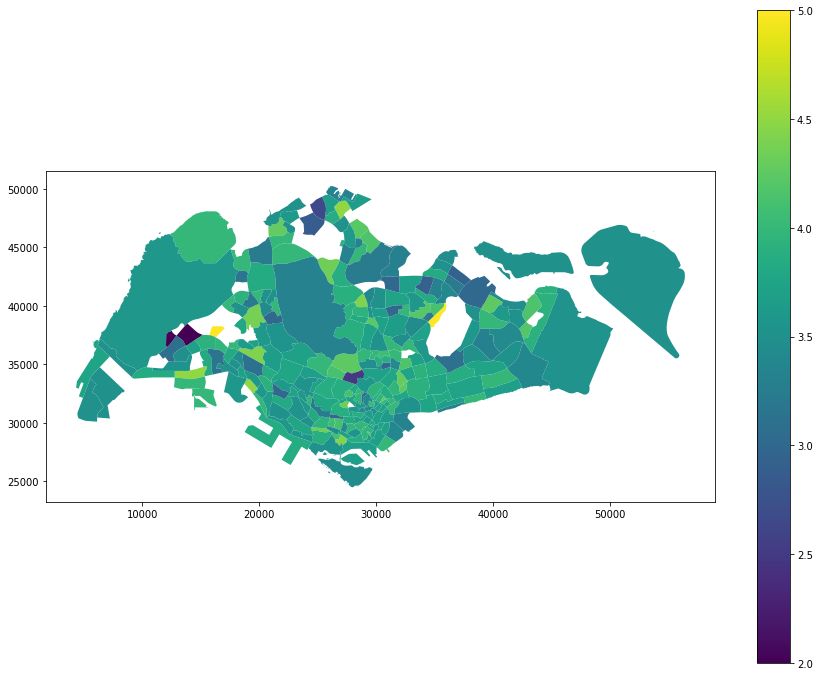

In [56]:
subzone_rest = final_restaurant.groupby('Subzone Name').mean().reset_index().sort_values(by='primaryRating', ascending=False)
subzone_rest = subzone_rest.set_index('Subzone Name')
subzone_rest = subzone_rest[['primaryRating', 'reviewCount']]
subzone_count = final_restaurant.groupby('Subzone Name').count()['name']
subzone_count = subzone_count.to_frame().merge(subzone.set_index('Subzone Name')['geometry'].to_frame(), left_index = True, right_index=True)
subzone_merge = subzone_rest.merge(subzone_count, left_index = True, right_index=True)
subzone_merge.columns = ['Avg Rating in Subzone', 'Avg Number of Reviews for each Restaurant', 'Number of Restaurants', 'geometry']
subzone_merge = gpd.GeoDataFrame(subzone_merge, geometry='geometry')
subzone_merge.plot(column='Avg Rating in Subzone', figsize=(15,12), legend=True)

In [57]:
subzone_merge = subzone_merge.reset_index()
subzone_merge.columns = ['subzone_name','avg_rating', 'avg_num_reviews_per_restaurants', 'num_restauarants', 'geometry']
subzone_merge['avg_num_reviews_per_restaurants'] = round(subzone_merge['avg_num_reviews_per_restaurants'])
subzone_merge['avg_rating'] = round(subzone_merge['avg_rating'],2)
subzone_merge.sort_values(by='num_restauarants', ascending=False)

subzone_name  avg_rating  avg_num_reviews_per_restaurants  \
67       CHINATOWN        3.95                             44.0   
131      BOULEVARD        3.74                             57.0   
167  MARINA CENTRE        3.64                             46.0   
182       SOMERSET        3.59                             46.0   
143      CITY HALL        3.71                             61.0   
..             ...         ...                              ...   
43        PANG SUA        4.00                              1.0   
35    ROCHOR CANAL        4.00                              3.0   
3           TUKANG        4.50                              9.0   
2        ADMIRALTY        4.50                              7.0   
276      CLEANTECH        2.00                              1.0   

     num_restauarants                                           geometry  
67                945  POLYGON Z ((29161.201 29723.071 0.000, 29189.0...  
131               667  POLYGON Z ((28223.652 32264.035 0.000, 28229.4...  
167               504  POLYGON Z ((31353.259 30694.761 0.000, 31354.6...  
182               454  POLYGON Z ((28677.443 31547.675 0.000, 28679.2...  
143               410  POLYGON Z ((30671.271 30867.512 0.000, 30645.0...  
..                ...                                                ...  
43                  1  POLYGON Z ((19156.473 44276.421 0.000, 19196.0...  
35                  1  POLYGON Z ((30757.127 31723.489 0.000, 30715.2...  
3                   1  POLYGON Z ((15436.019 34495.789 0.000, 15391.9...  
2                   1  POLYGON Z ((27468.829 48929.475 0.000, 27487.4...  
276                 1  POLYGON Z ((12612.355 37709.319 0.000, 12728.2...  

[277 rows x 5 columns]

In [92]:
import geojson
from geojson import dump
with open ('restaurants_subzone.gejson', 'w') as f:
    dump(subzone_merge, f)

ModuleNotFoundError: No module named 'geojson'

In [59]:
import json
subzone_json = json.loads(subzone_merge.to_json())
json_data = json.dumps(subzone_json)

In [83]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.palettes import brewer
from bokeh.models.widgets import Tabs, Panel 
from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select
from bokeh.layouts import widgetbox, row, column
from bokeh.transform import linear_cmap
from bokeh.layouts import column


#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)


#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]
#Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

#Add Hover Tool
hover = HoverTool(tooltips = [ ('Subzone Name','@subzone_name'),
                               ('Average Rating of Restaurant', '@avg_rating'),
                               ('Average Number of Reviews per Restaurant', '@avg_num_reviews_per_restaurants'),
                               ('Number of Restaurants in Subzone', '@num_restauarants')])


#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 1, high = 5)

#Define custom tick labels for color bar.
tick_labels = {'2':'2', '3':'3', '4':'4', '5':'5'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=4,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Avg Rating of Restaurants by Subzone', plot_height = 600 , plot_width = 950, toolbar_location = None, tools=[hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'avg_rating', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 0.8, hover_alpha = 1.0)
#Specify layout
p.add_layout(color_bar, 'below')


#Define a sequential multi-hue color palette.
palette2 = brewer['YlGnBu'][6]
#Reverse color order so that dark blue is highest obesity.
palette2 = 'Viridis256'

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper2 = LinearColorMapper(palette = palette2, low = 0, high = 300)

#Define custom tick labels for color bar.
tick_labels2 = {'1': '50', '2':'100', '3':'150', '4':'200', '5':'250', '6':'300'}

#Create color bar. 
color_bar2 = ColorBar(color_mapper=color_mapper2, label_standoff=5,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
color_mapper3 = linear_cmap(field_name = 'avg_num_reviews_per_restaurants', palette = palette2,
                            low = subzone_merge['avg_num_reviews_per_restaurants'].min(),high = subzone_merge['avg_num_reviews_per_restaurants'].max())

#Create figure object.
p1 = figure(title = 'Avg Number of Reviews (Popularity) per Restaraunt by Subzone', plot_height = 600 , plot_width = 950, toolbar_location = None, tools=[hover])
p1.xgrid.grid_line_color = None
p1.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p1.patches('xs','ys', source = geosource,color = color_mapper3,
          line_color = 'black', line_width = 0.25, fill_alpha = 0.8)


#Specify layout
p1.add_layout(color_bar2, 'below')

first = Panel(child=p, title='Avg Rating (Quality)')
second = Panel(child=p1, title='Avg Num of Reviews (Popularity)')
tabs = Tabs(tabs=[first,second])

slider = Slider(start = 1.0, end = 100, value = 1, step = 1, title = 'Min Number of Restaurants in Each Subzone')

#Display figure inline in Jupyter Notebook.
output_notebook()
#Display figure.
show(tabs)

Loading BokehJS ...

In [84]:
slider = Slider(start = 1.0, end = 100, value = 1, step = 1, title = 'Min Number of Restaurants in Each Subzone')


GeoJSONDataSource(id='2784', ...)

In [373]:
plan_rest = final_restaurant.groupby('Planning Area Name').mean().reset_index().sort_values(by='primaryRating', ascending=False)
plan_rest = plan_rest.set_index('Planning Area Name')
plan_rest = plan_rest[['primaryRating', 'reviewCount']]
plan_count = final_restaurant.groupby('Planning Area Name').count()['name']
plan_merge = plan_rest.merge(plan_count, left_index = True, right_index=True)
plan_merge.columns = ['Avg Rating in Planning Area', 'Avg Number of Reviews for each Restaurant', 'Number of Restaurants']
#planning = planning.set_index('Planning Area Name')
planning_merge = plan_merge.merge(planning, on = 'Planning Area Name')
planning_merge =gpd.GeoDataFrame(planning_merge, geometry='geometry')

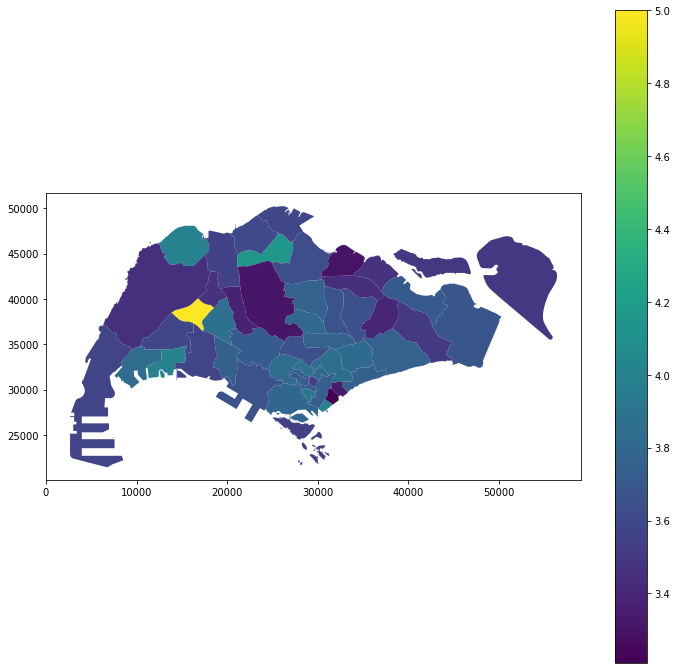

In [371]:
planning_merge.plot(column='Avg Rating in Planning Area', legend = True, figsize = (12,12))